<a href="https://colab.research.google.com/github/astrd/07_Redes_Neuronales/blob/main/Proyecto_Todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación**



### **1. Carga y acondicionamiento del conjunto de datos**
Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset



#### **1.1. Descarga del dataset desde la plataforma kaggle**

In [1]:
# Cargamos el fichero de autenticación de kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Descargamos el dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 95% 510M/534M [00:03<00:00, 130MB/s]
100% 534M/534M [00:03<00:00, 153MB/s]


In [3]:
# Descomprimimos el dataset
!unzip -q vegetable-image-dataset.zip

# **Estrategia 1: Red diseñada**


#### **1.2. Carga del dataset y acondicionamiento de datos**

1. Utilizamos el generador para mayor eficiencia en la carga de datos.
2. Utilizamos el parametro class_mode='categorical' para realizar One-hot encoding.
3. Con el parámetro rescale=1./255 normalizamos para disminuir el coste computacional.
4. En el generador de datos de train utilizamos **data augmentation** con el que modificamos las imágenes de entrada al entrenamiento con el fin de aumentar la capacidad de generalización del modelo. En el caso del modelo **from scratch** se aplican rotaciones, variaciones en los canales de la imageny desplazamientos verticales y horizontales.


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir los directorios de los conjuntos de datos
train_dir = 'Vegetable Images/train'
test_dir = 'Vegetable Images/test'
val_dir = 'Vegetable Images/validation'

# Definir el tamaño de imagen que se utilizará para el modelo
img_size = (128, 128)

# Definir el generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,
    channel_shift_range=0.3,
    width_shift_range=0.1, # Desplazamiento horizontal aleatorio
    height_shift_range=0.1, # Desplazamiento vertical aleatorio
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=32,
        shuffle = False,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

# Obtener los datos y las etiquetas de los generadores de datos
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()
x_val, y_val = val_generator.next()

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### **2. Inspección del conjunto de datos**

Found 15000 images belonging to 15 classes.
(64, 128, 128, 3)
(64, 15)


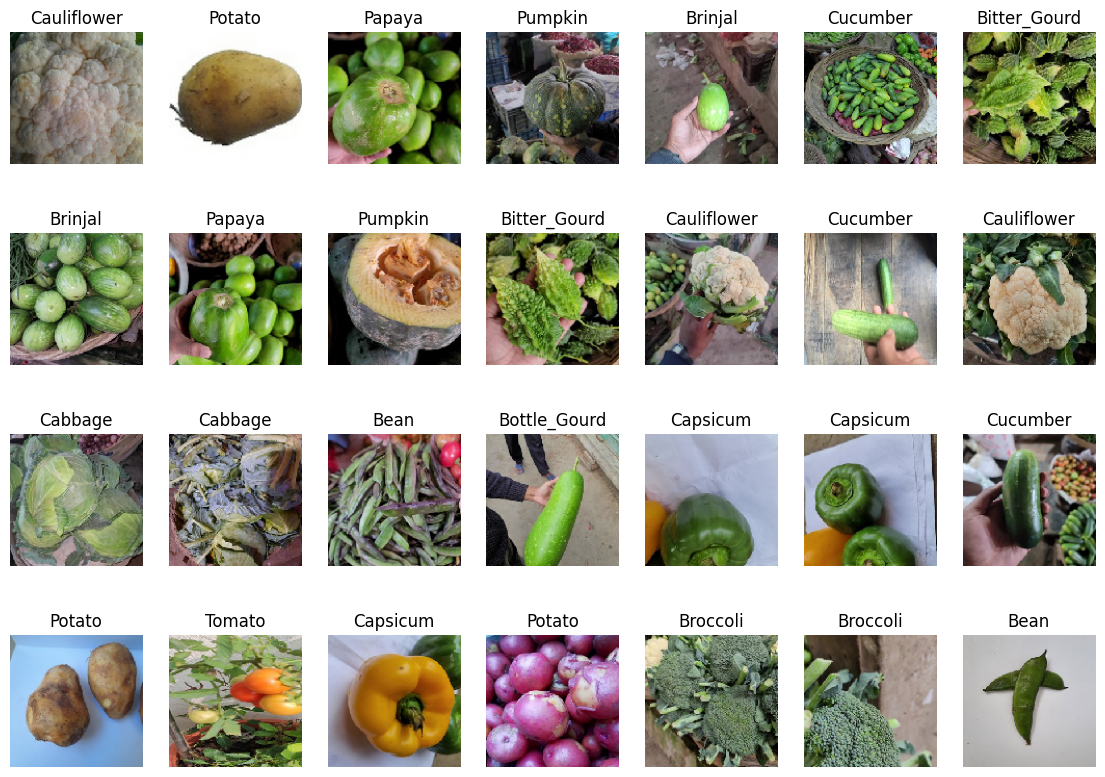

In [5]:
import matplotlib.pyplot as plt

# Definir el generador de datos para la visualización (sin preprocesado)
visual_datagen = ImageDataGenerator(rescale=1./255)
visual_generator = visual_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

x_visual, y_visual = visual_generator.next()

# Obtener la lista de nombres de las clases
class_names = list(visual_generator.class_indices.keys())

# Estructura del primer batch del conjunto de entrenamiento
print(x_train.shape)

# Estructura de las etiquetas del conjunto de entrenamiento 
print(y_train.shape)

fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_visual[n]
    plt.imshow(img)
    plt.axis('off')
    # Agregar el título de la clase correspondiente
    label_index = y_visual[n].argmax()
    plt.title(class_names[label_index])
plt.show()



### **3. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

#### **3.1. Búsqueda de hiperparámetros**


In [6]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.7 MB/s eta 0:00:00


##### **3.1.2. Definición de model builder**


*   weight_regularization = [1e-1,1e-2, 1e-3]
*   dropout = [0.0, 0.1, 0.25]
*   hp_learning_rate = [1e-1, 1e-2, 1e-3]
*   optimizer = [Adam, SGD]






In [7]:
import tensorflow as tf
import IPython
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping



class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

def model_builder(hp):
    #########################################
    ###### Definimos la arquitectura ########
    #########################################
    # Definir el factor de regularización de peso
    hp_weight = hp.Choice('weight_regularization', values = [1e-1,1e-2, 1e-3]) 
    # Definir la tasa de dropout
    hp_dropout = hp.Choice('dropout', values = [0.0, 0.1, 0.25])
    # Definir la tasa de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3]) 
    # Definir el optimizador
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
   # Crear el modelo
    model = Sequential()

    # Añadir capas convolucionales y de pooling
    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(hp_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2(hp_weight)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2))

    #Flatten the feature map
    model.add(layers.Flatten())

    #TOP MODEL
    model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(15,activation='softmax'))

    # Compilar el modelo
    if optimizer == 'adam':
        model.compile(optimizer=optimizers.Adam(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizers.SGD(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
        
    return model



##### **3.1.3. Definimos el tuner a utilizar**



*   Utilizamos el Hyperband.
*   El objetivo es optimizar el valor de acierto.
*   Máximo de épocas 20



In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     seed = 42)  

##### **3.1.4. Ejecutamos el tunner**


In [ ]:
tuner.search(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=20)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout is {best_hps.get('dropout')}. The 
optimal weight regularization is {best_hps.get('weight_regularization')} . The best optimizer is {best_hps.get('optimizer')}
""")

#### **3.2. Arquitectura adoptada**


##### **3.2.1. Hiperparámetros**


*   Los hiperparámetros han sido escogidos en base a los resultados recibidos tras ejecutar el tuner.


*   hp_weight = 0.001 -> peso utilizado para regulación l2 con el fin de reducir el overfitting.
*   hp_dropout = 0.1 -> tasa de dropout (apagado azaroso de conexiones neuronales) con el fin de reducir el overfitting.
*   learning_rate = 0.1 -> tasa de aprendizaje utilizada en el algoritmo optimizador.
*   optimizer = SGD -> algoritmo de optimización utilizado.

##### **3.2.2. Capas**

1.   Primera capa: 32 filtros tamaño 3x3, activación ReLU y max pooling
2.   Segunda capa: 64 filtros tamaño 3x3, activación ReLU y max pooling
3.   Se aplana el texto utilizando Flatten
4.   Top model para la clasificación de imágenes: 
    - 2 Capas densas de 128 entradas, activación por ReLU y dropout
    - Capa densa de 15 entradas, activación por softmax

##### **3.2.3. Otras arquitecturas**

Se han probado otras arquitecturas variando la complejidad de éstas, ya sea añadiendo más capas y otras técnicas para reducir el overfitting como **batch normalization** en las capas convolucionales, pero esta ha sido la adoptada finalmente debido a que ha sido la que nos ha retornado una mayor de tasa de acierto a la hora de probar el modelo con los datos de test.

##### **3.2.4. Código de la arquitectura**



In [13]:
import tensorflow as tf

# Definir el factor de regularización de peso
hp_weight = 0.001
# Definir la tasa de dropout
hp_dropout = 0.1
# Definir la tasa de aprendizaje
hp_learning_rate = 0.1

# Crear el modelo
model = Sequential()

# Añadir capas convolucionales y de pooling
model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(hp_weight)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=l2(hp_weight)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

#Flatten the feature map
model.add(layers.Flatten())

#TOP MODEL
model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
model.add(layers.Dropout(hp_dropout))
model.add(layers.Dense(128,activation='relu', kernel_regularizer=l2(hp_weight)))
model.add(layers.Dropout(hp_dropout))
model.add(layers.Dense(15,activation='softmax'))

# Definir el optimizador con la tasa de aprendizaje
optimizer = optimizers.SGD(hp_learning_rate)

# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

#### **3.3. Entrenamiento**



*   Definimos **earlystopping** con una paciencia de 3 épocas con el fin de evitar el sobreajuste y mejorar la eficiencia del entrenamiento.
*   Definimos los pasos por época con un tamaño de **batch** de 64.
* Definimos 100 épocas. Tamaño suficientemente amplio para que entre en acción el early stopping.




In [14]:
early_stopping = EarlyStopping(patience=5)
# Entrenar el modelo
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch=int(train_generator.samples/64), 
    epochs=100,
    callbacks=early_stopping)

# Evaluar el modelo con los datos de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/100
234/234 [==============================] - 54s 228ms/step - loss: 2.9330 - accuracy: 0.1451 - val_loss: 2.7407 - val_accuracy: 0.1793
Epoch 2/100
234/234 [==============================] - 53s 224ms/step - loss: 2.7503 - accuracy: 0.1972 - val_loss: 2.5242 - val_accuracy: 0.2640
Epoch 3/100
234/234 [==============================] - 53s 228ms/step - loss: 2.5132 - accuracy: 0.2722 - val_loss: 2.0903 - val_accuracy: 0.3760
Epoch 4/100
234/234 [==============================] - 53s 227ms/step - loss: 2.3292 - accuracy: 0.3388 - val_loss: 2.2487 - val_accuracy: 0.3370
Epoch 5/100
234/234 [==============================] - 52s 223ms/step - loss: 2.0488 - accuracy: 0.4203 - val_loss: 2.0446 - val_accuracy: 0.4237
Epoch 6/100
234/234 [==============================] - 53s 225ms/step - loss: 1.9158 - accuracy: 0.4758 - val_loss: 1.5368 - val_accuracy: 0.5843
Epoch 7/100
234/234 [==============================] - 53s 228ms/step - loss: 1.8210 - accuracy: 0.5093 - val_loss: 1.6361 -

### **4. Monitorización del proceso de entrenamiento para la toma de decisiones**




*   Implementamos la función para pintar la gráfica del entrenamiento del modelo.
*   Mostramos las funciones de: pérdida de entrenamiento/validación y aciertos de entrenamiento/validación.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
def pintarGrafica(epocas, modelo):
  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epocas), modelo.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epocas), modelo.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epocas), modelo.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epocas), modelo .history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()


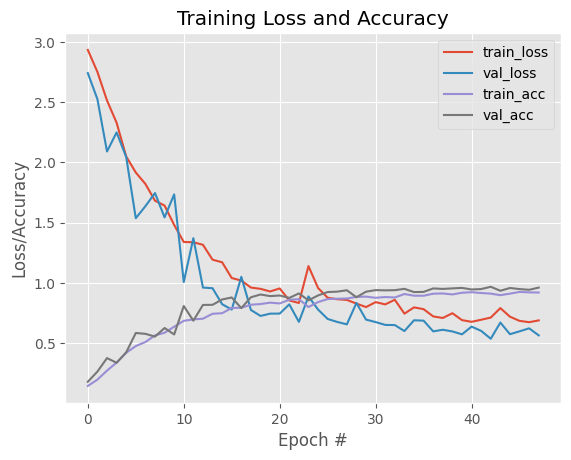

In [16]:
pintarGrafica(48, history)

### **5. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**



#### **5.1. Evaluación de modelo por cada clase**

In [17]:
from sklearn.metrics import classification_report

# Obtener las etiquetas verdaderas del conjunto de test
y_true = test_generator.classes

# Obtener las etiquetas predichas del conjunto de test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Generar el informe de clasificación
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


94/94 [==============================] - 6s 60ms/step
              precision    recall  f1-score   support

        Bean       0.97      0.97      0.97       200
Bitter_Gourd       0.98      0.94      0.96       200
Bottle_Gourd       0.98      0.96      0.97       200
     Brinjal       0.98      0.94      0.96       200
    Broccoli       0.95      0.98      0.97       200
     Cabbage       0.90      0.99      0.94       200
    Capsicum       0.99      1.00      1.00       200
      Carrot       1.00      0.98      0.99       200
 Cauliflower       0.98      0.95      0.97       200
    Cucumber       0.97      0.97      0.97       200
      Papaya       0.93      0.99      0.96       200
      Potato       0.97      0.99      0.98       200
     Pumpkin       0.94      0.92      0.93       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.99      0.92      0.96       200

    accuracy                           0.97      3000
   macro avg       0.97   

#### **5.2. Evaluación total del modelo**

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

94/94 [==============================] - 6s 59ms/step - loss: 0.5485 - accuracy: 0.9683
Test loss: 0.548520565032959
Test accuracy: 0.9683333039283752


# **Estrategia 2: Red pre-entrenada**


## **Arquitectura 1: InceptionV3**



#### **1.2 Carga del dataset y acondicionamiento de datos**
1. Utilizamos un generador de imágenes para mayor eficiencia en la carga de datos.
2. Utilizamos el parametro class_mode='categorical' para realizar One-hot encoding.
3. Establecemos un batch size de 64 muestras.
4. Llevamos a cabo un preprocesado para el uso de la Red Neuronal InceptionV3 (transforma los valores de las imágenes entre -1 y 1.
5. Establecemos tres tipos de transformaciones para llevar a cabo data augmentation sobr el conjunto de datos de entrenamiento.



In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils


# Definimos los directorios de los conjuntos de datos
train_dir = 'Vegetable Images/train'
test_dir = 'Vegetable Images/test'
val_dir = 'Vegetable Images/validation'

# Definimos el tamaño de imagen que se utilizará para el modelo
img_size = (128,128)

# Definir el generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
                                   rotation_range=90, # grados de rotacion aleatoria
                                   horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
                                   zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=64,
        shuffle = False,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Obtener los datos y las etiquetas de los generadores de datos
x_train, y_train = test_generator.next()
x_test, y_test = test_generator.next()
x_val, y_val = val_generator.next()



Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### **2. Inspección del conjunto de datos**

Found 15000 images belonging to 15 classes.
(64, 128, 128, 3)
(64, 15)


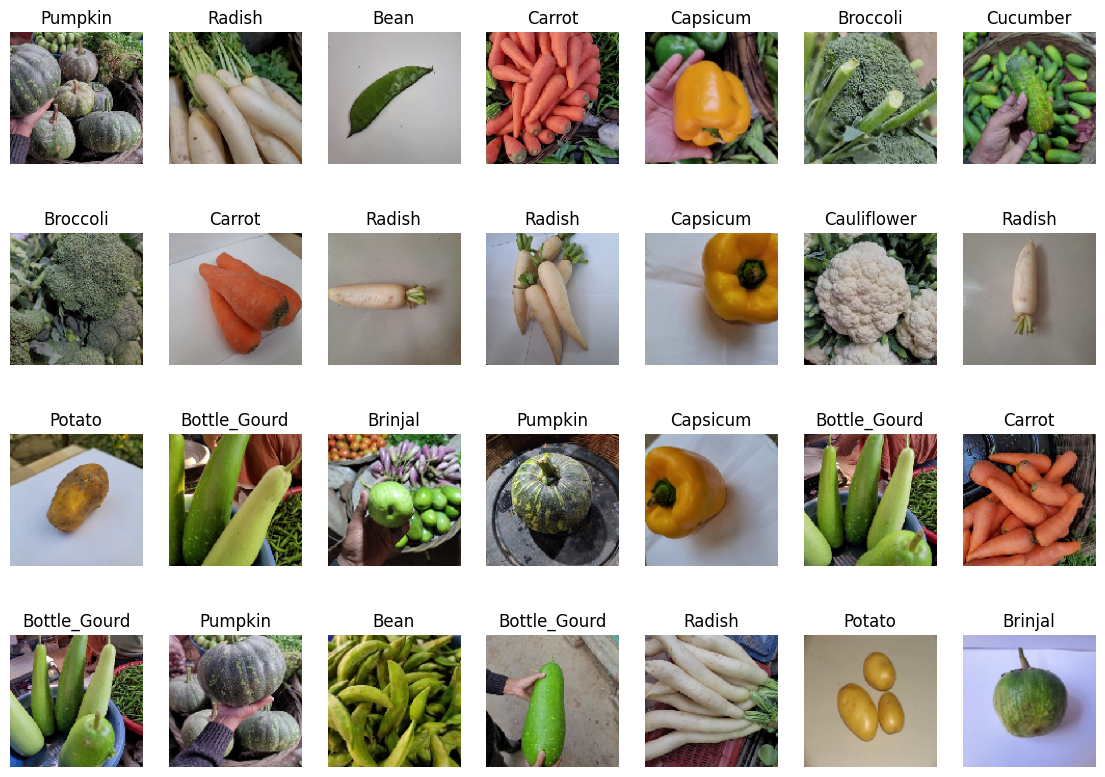

In [ ]:
import matplotlib.pyplot as plt

# Definir el generador de datos para la visualización (sin preprocesado)
visual_datagen = ImageDataGenerator(rescale=1./255)
visual_generator = visual_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

x_visual, y_visual = visual_generator.next()

# Obtener la lista de nombres de las clases
class_names = list(visual_generator.class_indices.keys())

# Estructura del primer batch del conjunto de entrenamiento
print(x_train.shape)

# Estructura de las etiquetas del conjunto de entrenamiento 
print(y_train.shape)

fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_visual[n]
    plt.imshow(img)
    plt.axis('off')
    # Agregar el título de la clase correspondiente
    label_index = y_visual[n].argmax()
    plt.title(class_names[label_index])
plt.show()


### **3. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

En este caso se va a utilizar como red neuronal InceptionV3 con los pesos de imagenet, entrenada con un gran numero de imágenes para clasificación.


#### **3.1 Transfer Learning model**

En primer lugar se va a llevar a cabo el entrenamiento de un modelo sustentado en la parte convoluional de InceptionV3. Posteriormente se van a añadir 2 capas densas con batch normalization, weight regularization y dropout para obtener las predicciones de las 15 clases disponibles en el dataset.

Para ajustar el modelo se ha utilizado keras tuner con el objetivo de ajustar tano el porcentaje de dropout como el parámetro alpha del weight regularization y el learning rate del stochastic gradient descent algorithm utilizado en el entrenamiento.

In [ ]:
from keras.applications import InceptionV3

base_model = InceptionV3(include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(75,75,3))


87910968/87910968 [==============================] - 4s 0us/step


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import regularizers

import numpy as np

# Evitar que los pesos se modifiquen en la parte convolucional
base_model.trainable = False 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output 

x = Flatten()(last) 
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc1')(x) 
x = BatchNormalization()(x) 
x = Dropout(0.1)(x) 
x = Dense(15, activation='softmax', name='predictions')(x) 
model = Model(base_model.input, x) 

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: ignored

In [ ]:
# Compilamos el modelo
model.compile(optimizer=optimizers.SGD(0.01), loss='categorical_crossentropy', metrics=['accuracy']) 

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
model.summary() 

# Entrenamos el modelo 
H = model.fit(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=30) 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

### **4. Monitorización del proceso de entrenamiento para la toma de decisiones**

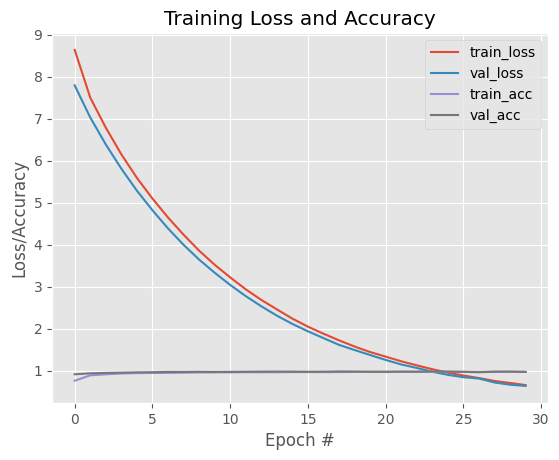

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, 30), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 30), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, 30), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, 30), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

plot_history(H)


### **5. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

Una vez entrenada la red neuronal se va a llevar a cabo la evaluación del modelo con los datos de test. 

Para tratar de mejorar los resultados se va a llevar a cabo un proceso de fine tuning en el que, del modelo base convolucional de Inception V3, se va a desbloquear el ultimo bloque

In [ ]:
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(test_generator) 
# Obtener el report de clasificación
print(classification_report(val_generator.classes, predictions.argmax(axis=1), target_names=class_names)) 

[INFO]: Evaluando el modelo...
47/47 [==============================] - 8s 130ms/step
              precision    recall  f1-score   support

        Bean       0.99      0.98      0.99       200
Bitter_Gourd       0.99      0.96      0.98       200
Bottle_Gourd       0.99      0.98      0.99       200
     Brinjal       0.82      0.99      0.90       200
    Broccoli       0.98      0.98      0.98       200
     Cabbage       0.99      0.98      0.98       200
    Capsicum       0.99      0.98      0.99       200
      Carrot       0.99      0.97      0.98       200
 Cauliflower       0.99      0.97      0.98       200
    Cucumber       0.96      0.96      0.96       200
      Papaya       0.99      0.90      0.94       200
      Potato       0.99      0.98      0.99       200
     Pumpkin       0.99      0.95      0.97       200
      Radish       0.95      1.00      0.97       200
      Tomato       0.97      0.96      0.97       200

    accuracy                           0.97     

#### **5.1 Optimización de hiperparámetros**

In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import IPython
import keras_tuner as kt

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)


def model_builder(hp, base_model):
  
  base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING

  # Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
  last = base_model.layers[-1].output 

  x = Flatten()(last) 
  hp_weight = hp.Choice('weight_regularization', values = [1e-2, 1e-3, 1e-4]) 
  x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(hp_weight), name='fc1')(x) 
  x = BatchNormalization()(x) 
  hp_dropout = hp.Choice('dropout', values = [0.0, 0.1, 0.2])
  x = Dropout(hp_dropout)(x) 
  x = Dense(15, activation='softmax', name='predictions')(x) 
  model = Model(base_model.input, x) 

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  model.compile(optimizer=optimizers.SGD(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 

  return model

In [ ]:
base_model_hp = InceptionV3(include_top=False,
                    weights="imagenet",
                    pooling='avg',
                    input_shape=(75,75,3))
 

tuner = kt.Hyperband(lambda hp: model_builder(hp, base_model_hp),
                     objective='val_accuracy',
                     max_epochs=20,
                     seed=42) 

In [ ]:
tuner.search(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=20,
             callbacks = [ClearTrainingOutput(), EarlyStoppingCallback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout is {best_hps.get('dropout')}. The 
optimal weight regularization is {best_hps.get('weight_regularization')}
""")




It returns the following:

Best val_accuracy So Far: 0.9553333520889282
Total elapsed time: 02h 03m 27s

The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.01. The optimal dropout is 0.0. The 
optimal weight regularization is 0.01

#### **5.2 Fine Tuning model**

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.applications import VGG16, imagenet_utils
from keras.utils import to_categorical
from keras import optimizers
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras import Model
from keras import regularizers
import numpy as np

from keras.applications import InceptionV3

base_model = InceptionV3(include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(75,75,3))

# Congelamos las capas hasta el último bloque convolucional que comienza con la capa:  
for layer in base_model.layers: 
  if layer.name == 'mixed9': 
    break 
  layer.trainable = False 
  print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output 

x = Flatten()(last) 
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc1')(x) 
x = BatchNormalization()(x) 
x = Dropout(0.1)(x) 
x = Dense(15, activation='softmax', name='predictions')(x) 
model_tuning = Model(base_model.input, x) 

model_tuning.summary()

87910968/87910968 [==============================] - 1s 0us/step
Capa input_1 congelada...
Capa conv2d congelada...
Capa batch_normalization congelada...
Capa activation congelada...
Capa conv2d_1 congelada...
Capa batch_normalization_1 congelada...
Capa activation_1 congelada...
Capa conv2d_2 congelada...
Capa batch_normalization_2 congelada...
Capa activation_2 congelada...
Capa max_pooling2d congelada...
Capa conv2d_3 congelada...
Capa batch_normalization_3 congelada...
Capa activation_3 congelada...
Capa conv2d_4 congelada...
Capa batch_normalization_4 congelada...
Capa activation_4 congelada...
Capa max_pooling2d_1 congelada...
Capa conv2d_8 congelada...
Capa batch_normalization_8 congelada...
Capa activation_8 congelada...
Capa conv2d_6 congelada...
Capa conv2d_9 congelada...
Capa batch_normalization_6 congelada...
Capa batch_normalization_9 congelada...
Capa activation_6 congelada...
Capa activation_9 congelada...
Capa average_pooling2d congelada...
Capa conv2d_5 congelada...
Ca

In [ ]:
import tensorflow as tf

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)

# Compilamos el modelo
model_tuning.compile(optimizer=optimizers.SGD(0.01), loss='categorical_crossentropy', metrics=['accuracy']) 


# Entrenamos el modelo 
H = model_tuning.fit(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=30, callbacks = [EarlyStoppingCallback]) 

Epoch 1/30
234/234 [==============================] - 103s 379ms/step - loss: 8.3533 - accuracy: 0.8478 - val_loss: 7.6391 - val_accuracy: 0.9540
Epoch 2/30
234/234 [==============================] - 85s 363ms/step - loss: 7.2947 - accuracy: 0.9501 - val_loss: 6.8868 - val_accuracy: 0.9740
Epoch 3/30
234/234 [==============================] - 89s 380ms/step - loss: 6.6097 - accuracy: 0.9632 - val_loss: 6.2579 - val_accuracy: 0.9803
Epoch 4/30
234/234 [==============================] - 91s 388ms/step - loss: 6.0050 - accuracy: 0.9705 - val_loss: 5.6935 - val_accuracy: 0.9820
Epoch 5/30
234/234 [==============================] - 90s 385ms/step - loss: 5.4584 - accuracy: 0.9767 - val_loss: 5.1803 - val_accuracy: 0.9850
Epoch 6/30
234/234 [==============================] - 93s 398ms/step - loss: 4.9702 - accuracy: 0.9788 - val_loss: 4.7164 - val_accuracy: 0.9877
Epoch 7/30
234/234 [==============================] - 89s 379ms/step - loss: 4.5207 - accuracy: 0.9829 - val_loss: 4.2942 - val_a

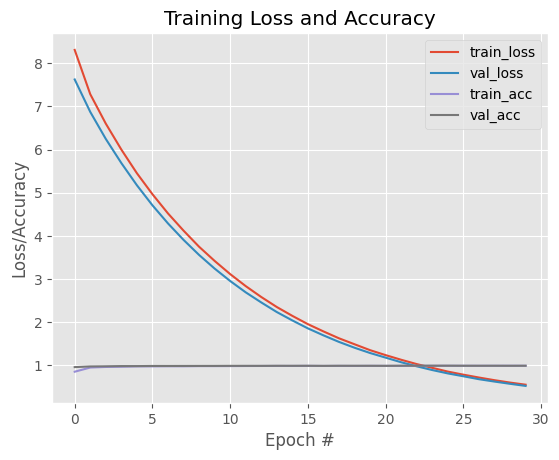

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions_tuning = model_tuning.predict(test_generator) 
# Obtener el report de clasificación
print(classification_report(test_generator.classes, predictions_tuning.argmax(axis=1), target_names=class_names)) 

[INFO]: Evaluando el modelo...
47/47 [==============================] - 7s 115ms/step
              precision    recall  f1-score   support

        Bean       0.98      1.00      0.99       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.98      0.99      0.98       200
    Broccoli       1.00      0.99      1.00       200
     Cabbage       0.99      0.99      0.99       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.99      0.99       200
    Cucumber       1.00      0.97      0.99       200
      Papaya       0.99      0.99      0.99       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      1.00      1.00       200
      Radish       1.00      0.99      1.00       200
      Tomato       1.00      0.98      0.99       200

    accuracy                           0.99     

## **2. Arquitectura 2: VGG16** 


#### **2.2 Carga del dataset y acondicionamiento de datos**
De forma similar a la anterior arquitectura
1. Utilizamos un generador de imágenes para mayor eficiencia en la carga de datos.
2. Utilizamos el parametro class_mode='categorical' para realizar One-hot encoding.
3. Establecemos un batch size de 64 muestras.
4. Llevamos a cabo un preprocesado para el uso de la Red Neuronal VGG16 (transforma los valores de las imágenes entre -1 y 1.
5. Establecemos tres tipos de transformaciones para llevar a cabo data augmentation sobr el conjunto de datos de entrenamiento.



In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils


# Definimos los directorios de los conjuntos de datos
train_dir = 'Vegetable Images/train'
test_dir = 'Vegetable Images/test'
val_dir = 'Vegetable Images/validation'

# Definimos el tamaño de imagen que se utilizará para el modelo
img_size = (128,128)

# Definir el generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                   rotation_range=90, # grados de rotacion aleatoria
                                   horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
                                   zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=64,
        shuffle = False,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Obtener los datos y las etiquetas de los generadores de datos
x_train, y_train = test_generator.next()
x_test, y_test = test_generator.next()
x_val, y_val = val_generator.next()



Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


Found 15000 images belonging to 15 classes.
(64, 128, 128, 3)
(64, 15)


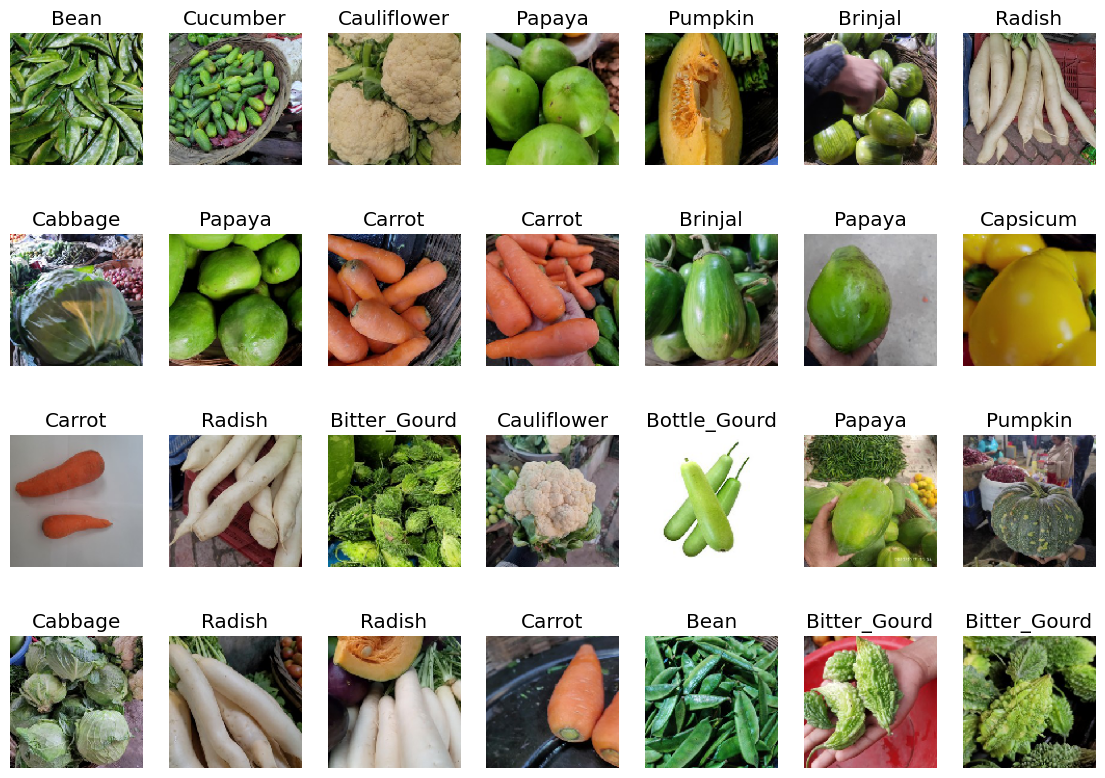

In [ ]:
import matplotlib.pyplot as plt

# Definir el generador de datos para la visualización (sin preprocesado)
visual_datagen = ImageDataGenerator(rescale=1./255)
visual_generator = visual_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

x_visual, y_visual = visual_generator.next()

# Obtener la lista de nombres de las clases
class_names = list(visual_generator.class_indices.keys())

# Estructura del primer batch del conjunto de entrenamiento
print(x_train.shape)

# Estructura de las etiquetas del conjunto de entrenamiento 
print(y_train.shape)

fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_visual[n]
    plt.imshow(img)
    plt.axis('off')
    # Agregar el título de la clase correspondiente
    label_index = y_visual[n].argmax()
    plt.title(class_names[label_index])
plt.show()


### **3. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

En este caso se va a utilizar como red neuronal VGG16 con los pesos de imagenet, entrenada con un gran numero de imágenes para clasificación.


#### **3.1 Transfer Learning model**

En primer lugar se va a llevar a cabo el entrenamiento de un modelo sustentado en la parte convoluional de VGG16. Posteriormente se van a añadir 2 capas densas con batch normalization, weight regularization y dropout para obtener las predicciones de las 15 clases disponibles en el dataset.

Para ajustar el modelo se ha utilizado keras tuner con el objetivo de ajustar tano el porcentaje de dropout como el parámetro alpha del weight regularization y el learning rate del stochastic gradient descent algorithm utilizado en el entrenamiento.

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

# Load the pre-trained VGG16 model
base_model_vgg = VGG16(include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(75,75,3))



In [ ]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import regularizers
import numpy as np

base_model_vgg.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model_vgg.layers[-1].output 

x = Flatten()(last) 
#weight regularation
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='fc1')(x) 
#batch normalization
x = BatchNormalization()(x) 
#dropout
#x = Dropout(0.1)(x)
x = Dense(15, activation='softmax', name='predictions')(x) 
modeloVGG = Model(base_model_vgg.input, x) 

compilamos el modelo

In [ ]:
#learning rate = 0.001
modeloVGG.compile(optimizer=optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
#model.summary() 

# Entrenamos el modelo 
historyVGG = modeloVGG.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch = int(train_generator.samples / 64),
              epochs=30) 



Epoch 1/30
234/234 [==============================] - 88s 371ms/step - loss: 2.4047 - accuracy: 0.4308 - val_loss: 1.4550 - val_accuracy: 0.7117
Epoch 2/30
234/234 [==============================] - 84s 359ms/step - loss: 1.3543 - accuracy: 0.7715 - val_loss: 1.0635 - val_accuracy: 0.8550
Epoch 3/30
234/234 [==============================] - 84s 360ms/step - loss: 1.1131 - accuracy: 0.8432 - val_loss: 0.9197 - val_accuracy: 0.8917
Epoch 4/30
234/234 [==============================] - 85s 365ms/step - loss: 0.9934 - accuracy: 0.8753 - val_loss: 0.8417 - val_accuracy: 0.9150
Epoch 5/30
234/234 [==============================] - 86s 369ms/step - loss: 0.9287 - accuracy: 0.8954 - val_loss: 0.7926 - val_accuracy: 0.9287
Epoch 6/30
234/234 [==============================] - 85s 365ms/step - loss: 0.8838 - accuracy: 0.9082 - val_loss: 0.7595 - val_accuracy: 0.9373
Epoch 7/30
234/234 [==============================] - 86s 368ms/step - loss: 0.8462 - accuracy: 0.9169 - val_loss: 0.7366 - val_ac

### **4. Monitorización del proceso de entrenamiento para la toma de decisiones**

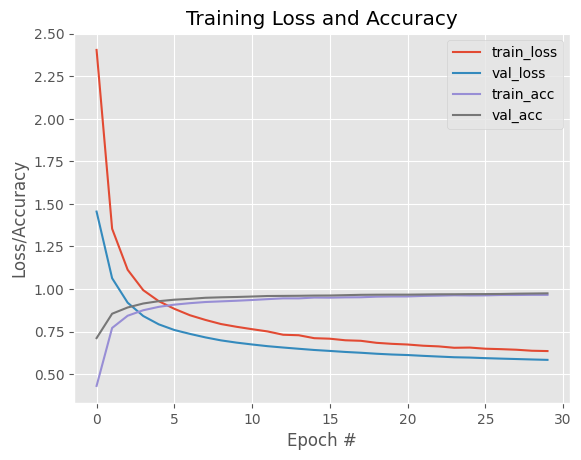

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), historyVGG.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), historyVGG.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), historyVGG.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), historyVGG.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### **5. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

De forma similiar a la anterior arquitectura una vez entrenada la red neuronal se va a llevar a cabo la evaluación del modelo con los datos de test. 

Para tratar de mejorar los resultados se va a llevar a cabo un proceso de fine tuning en el que, del modelo base convolucional de VGG16, se va a desbloquear el ultimo bloque

In [ ]:
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

# Evaluación del modelo
print("[INFO]: Evaluando el modelo VGG16...")
predictions = modeloVGG.predict(test_generator) 
# Obtener el report de clasificación
print(classification_report(val_generator.classes, predictions.argmax(axis=1), target_names=class_names)) 

[INFO]: Evaluando el modelo VGG16...
47/47 [==============================] - 9s 169ms/step
              precision    recall  f1-score   support

        Bean       0.97      0.98      0.98       200
Bitter_Gourd       0.99      0.97      0.98       200
Bottle_Gourd       0.99      0.98      0.99       200
     Brinjal       0.91      0.97      0.94       200
    Broccoli       0.96      0.97      0.97       200
     Cabbage       0.99      0.99      0.99       200
    Capsicum       1.00      0.96      0.98       200
      Carrot       0.99      1.00      1.00       200
 Cauliflower       0.98      0.98      0.98       200
    Cucumber       0.98      0.96      0.97       200
      Papaya       0.95      0.94      0.94       200
      Potato       0.98      1.00      0.99       200
     Pumpkin       1.00      0.98      0.99       200
      Radish       0.99      0.98      0.99       200
      Tomato       0.99      0.98      0.98       200

    accuracy                           0.9

#### **5.1 Optimización de hiperparámetros**

In [ ]:
from tensorflow.keras.applications import VGG16, imagenet_utils
import tensorflow as tf
import IPython
import keras_tuner as kt
from keras.models import Sequential
from keras import layers
from keras.applications import VGG16, imagenet_utils
from keras.utils import to_categorical
from keras import optimizers
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras import Model
from keras import regularizers
import numpy as np

base_model_vgg_hb = VGG16(include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(75,75,3))

tuner_VGG = kt.Hyperband(lambda hp: model_builder(hp, base_model_vgg_hb),
                     objective='val_accuracy',
                     max_epochs=20,
                     seed=42,
                     overwrite=True) 


In [ ]:
tuner_VGG.search(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=20,
             callbacks = [ClearTrainingOutput(), EarlyStoppingCallback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout is {best_hps.get('dropout')}. The 
optimal weight regularization is {best_hps.get('weight_regularization')}
""")




Despues de ejecutar estos hiperparametros encontramos un mejor valor de accuracy de 0.9313333630561829 y weight_regularization= 0.01, dropout=0.1
,learning_rate= 0.01

#### **5.2 Fine Tuning model**

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.applications import VGG16, imagenet_utils
from keras.utils import to_categorical
from keras import optimizers
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from keras import Model
from keras import regularizers
import numpy as np


base_model_vgg_ft = VGG16(include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(75,75,3))

# Congelamos las capas hasta el último bloque convolucional que comienza con la capa:  
for layer in base_model_vgg_ft.layers: 
  if layer.name == 'block5_pool': 
    break 
  layer.trainable = False 
  print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model_vgg_ft.layers[-1].output 

x = Flatten()(last) 
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc1')(x) 
x = BatchNormalization()(x) 
x = Dropout(0.1)(x) 
x = Dense(15, activation='softmax', name='predictions')(x) 
model_tuning_vgg = Model(base_model_vgg_ft.input, x) 

model_tuning_vgg.summary()

Capa input_3 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...
Capa block5_conv3 congelada...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75

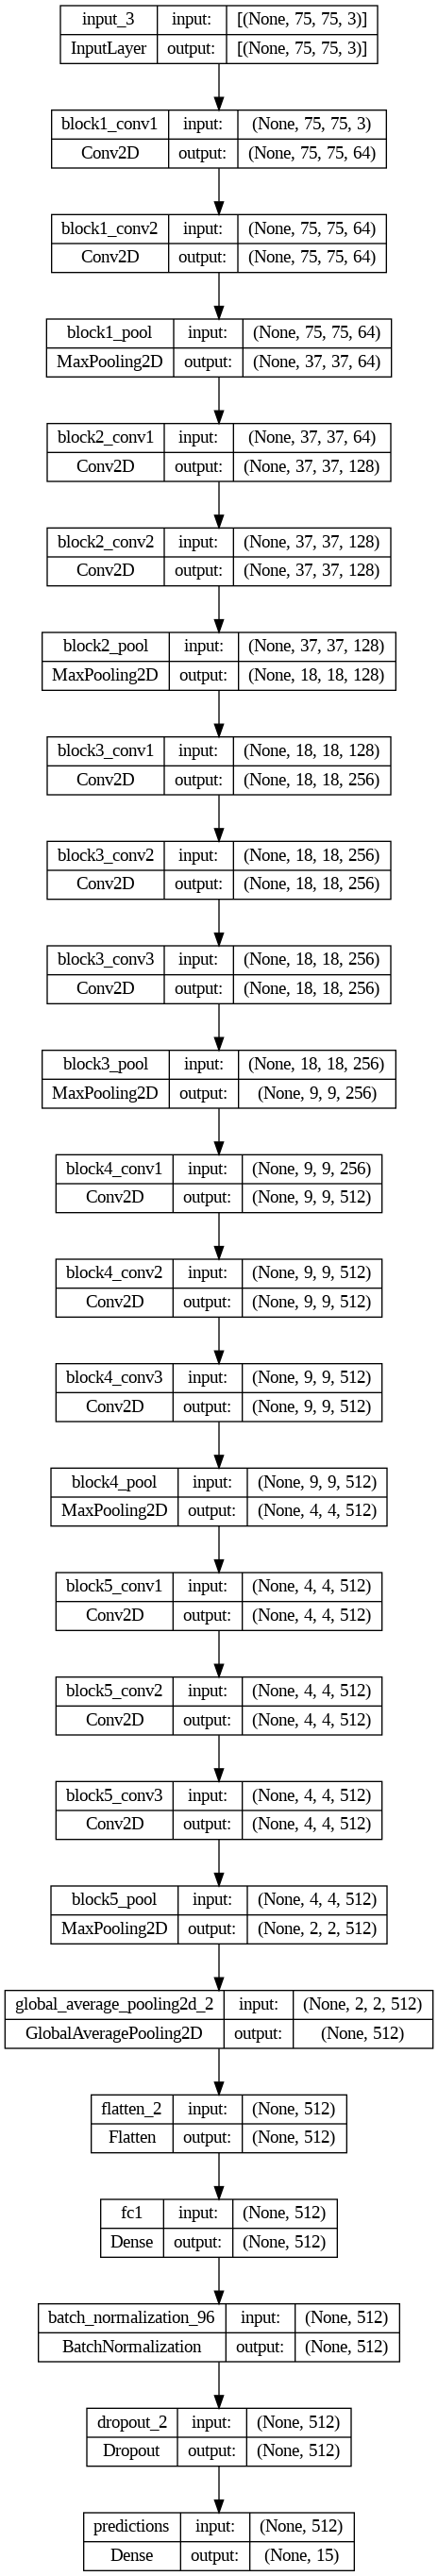

In [ ]:
tf.keras.utils.plot_model(model_tuning_vgg, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)

# Compilamos el modelo
model_tuning_vgg.compile(optimizer=optimizers.SGD(0.01), loss='categorical_crossentropy', metrics=['accuracy']) 


# Entrenamos el modelo 
history_vgg_ft = model_tuning_vgg.fit(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=30, callbacks = [EarlyStoppingCallback]) 

Epoch 1/30
234/234 [==============================] - 90s 380ms/step - loss: 5.5179 - accuracy: 0.8224 - val_loss: 4.8286 - val_accuracy: 0.9533
Epoch 2/30
234/234 [==============================] - 93s 395ms/step - loss: 4.6663 - accuracy: 0.9418 - val_loss: 4.3418 - val_accuracy: 0.9763
Epoch 3/30
234/234 [==============================] - 89s 382ms/step - loss: 4.2155 - accuracy: 0.9583 - val_loss: 3.9376 - val_accuracy: 0.9843
Epoch 4/30
234/234 [==============================] - 89s 379ms/step - loss: 3.8183 - accuracy: 0.9669 - val_loss: 3.5803 - val_accuracy: 0.9863
Epoch 5/30
234/234 [==============================] - 89s 381ms/step - loss: 3.4711 - accuracy: 0.9719 - val_loss: 3.2584 - val_accuracy: 0.9887
Epoch 6/30
234/234 [==============================] - 88s 377ms/step - loss: 3.1558 - accuracy: 0.9756 - val_loss: 2.9626 - val_accuracy: 0.9910
Epoch 7/30
234/234 [==============================] - 89s 382ms/step - loss: 2.8741 - accuracy: 0.9778 - val_loss: 2.6973 - val_ac

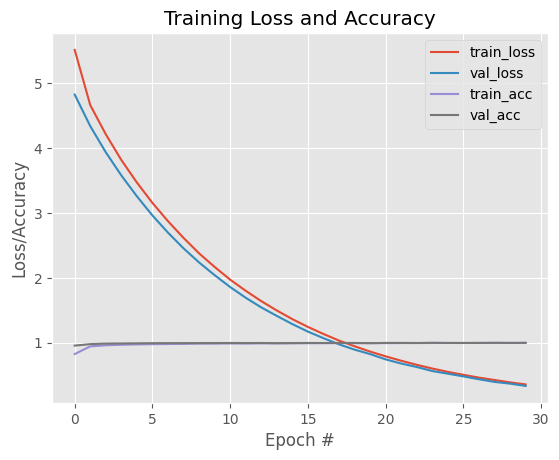

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), history_vgg_ft.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), history_vgg_ft.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), history_vgg_ft.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), history_vgg_ft.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions_tuning_vgg = model_tuning_vgg.predict(test_generator) 
# Obtener el report de clasificación
print(classification_report(test_generator.classes, predictions_tuning_vgg.argmax(axis=1), target_names=class_names)) 

[INFO]: Evaluando el modelo...
47/47 [==============================] - 6s 125ms/step
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      1.00       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       0.99      1.00      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      0.99      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.99      0.99       200
    Cucumber       1.00      1.00      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      0.99      1.00       200
     Pumpkin       0.99      0.99      0.99       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      1.00       200

    accuracy                           1.00     

## 3. Comparacion de modelos

En este apartado voy a comparar los modelos entre sí para ver cual tiene la mejor exactitud y perdida.

In [ ]:
from sklearn.metrics import classification_report

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Compare the results of the first model
print("[INFO]: Classification report for Model 1:")
print(classification_report(test_generator.classes, predictions_tuning.argmax(axis=1), target_names=class_names))

# Compare the results of the second model
print("[INFO]: Classification report for Model 2:")
print(classification_report(test_generator.classes, predictions_tuning_vgg.argmax(axis=1), target_names=class_names))


[INFO]: Classification report for Model 1:
              precision    recall  f1-score   support

        Bean       0.98      1.00      0.99       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.98      0.99      0.98       200
    Broccoli       1.00      0.99      1.00       200
     Cabbage       0.99      0.99      0.99       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.99      0.99       200
    Cucumber       1.00      0.97      0.99       200
      Papaya       0.99      0.99      0.99       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      1.00      1.00       200
      Radish       1.00      0.99      1.00       200
      Tomato       1.00      0.98      0.99       200

    accuracy                           0.99      3000
   macro avg       0.99      0.99    

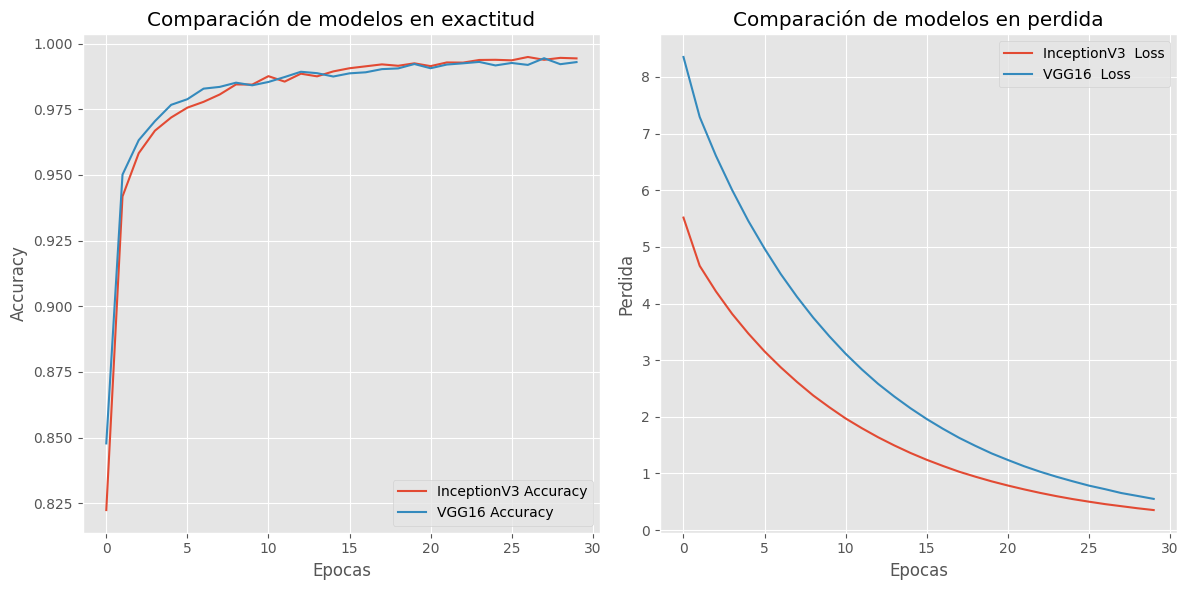

In [ ]:
import matplotlib.pyplot as plt

InceptionV3_tuning = history_vgg_ft
VGG16_tuning = H

plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(InceptionV3_tuning.history['accuracy'], label='InceptionV3 Accuracy')
plt.plot(VGG16_tuning.history['accuracy'], label='VGG16 Accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.title('Comparación de modelos en exactitud')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(InceptionV3_tuning.history['loss'], label='InceptionV3  Loss')
plt.plot(VGG16_tuning.history['loss'], label='VGG16  Loss')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.title('Comparación de modelos en perdida')
plt.legend()


plt.tight_layout()
plt.show()


Al comparar los modelos encontramos que el modelo InceptionV3 es superior al VGG16 aunque ambos tengan una exactitud muy cerca al 1. Comparando las perdidas el modelo InceptionV3 también tiene una mejor perdida al ser esta la más cercana al 0.

En conclusión el mejor modelo es el InceptionV3 que es el que tiene mejor rendimiento. 